In [1]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
)
from sklearn.preprocessing import (
    RobustScaler,
    OneHotEncoder,
    TargetEncoder,
)
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    r2_score,
    mean_absolute_error,
)
import scipy as sp

from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression
from sklearn.compose import TransformedTargetRegressor

import time
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
import re

from common import (
    CustomOneHotEncoder,
    apply_onehot_encoder,
    apply_custom_encoder,
    compare_pipelines,
    grid_search,
    get_linear_regression_scores,
    build_pipeline,
    plot_predictions,
)

In [2]:
pd.set_option("display.max_colwidth", None)

In [3]:
data = pd.read_csv("clean_data.csv")
data.drop(columns="Unnamed: 0", inplace=True)
data

,PrimaryPropertyType,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,...,ElectricityUse(Percentage),SteamUse(Percentage),NaturalGasUse(Percentage),LargestUseTypeGFA(Percentage),SecondLargestUseTypeGFA(Percentage),ThirdLargestUseTypeGFA(Percentage),ParkingGFA(Percentage),NumberOfYearsENERGYSTARCertified,BuildingAge,NumberOfPropertyUses
0,Leisure,47.61220,-122.33799,0.30103,1.113943,4.946624,Leisure,None,None,60.0,...,54.61,27.73,17.66,100.00,0.00,0.00,0.00,0.0,89,1
1,Leisure,47.61317,-122.33393,0.30103,1.079181,5.015221,Leisure,ServiceFacility,Leisure,61.0,...,38.66,0.00,61.34,80.99,14.55,4.46,14.55,0.0,20,3
2,Leisure,47.61393,-122.33810,0.30103,1.623249,5.980508,Leisure,None,None,43.0,...,68.23,29.71,2.06,79.12,0.00,0.00,20.57,0.0,47,1
3,Leisure,47.61412,-122.33664,0.30103,1.041393,4.787609,Leisure,None,None,56.0,...,40.75,32.59,26.66,100.00,0.00,0.00,0.00,0.0,90,1
4,Leisure,47.61375,-122.34047,0.30103,1.278754,5.244478,Leisure,ServiceFacility,Leisure,75.0,...,37.88,0.00,62.12,70.31,38.73,0.00,35.31,0.0,36,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1532,ServiceFacility,47.54067,-122.37441,0.30103,0.301030,4.261548,Leisure,None,None,NaN,...,67.84,0.00,32.16,100.00,0.00,0.00,0.00,0.0,34,1
1533,ServiceFacility,47.59625,-122.32283,0.30103,0.301030,4.204147,Leisure,None,None,NaN,...,41.73,0.00,58.27,100.00,0.00,0.00,0.00,0.0,12,1
1534,ServiceFacility,47.63644,-122.35784,0.30103,0.301030,4.119190,Leisure,ServiceFacility,Leisure,NaN,...,31.08,0.00,68.92,57.63,42.37,0.00,0.00,0.0,42,3
1535,ServiceFacility,47.52832,-122.32431,0.30103,0.301030,4.149281,Leisure,ServiceFacility,School,NaN,...,48.49,0.00,51.51,46.81,46.10,3.43,0.00,0.0,27,5


We will set aside a data set that contains energy star score information

In [4]:
energy_data = data.copy()
energy_data = energy_data.loc[~energy_data["ENERGYSTARScore"].isna()]

# Separation of training and test data

In [5]:
y_energy_use = data["SiteEnergyUse(kBtu)"]
X = data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
        "NumberOfYearsENERGYSTARCertified",
        "ENERGYSTARScore",
    ],
    axis=1,
)

In [6]:
def split():
    return train_test_split(X, y_energy_use, test_size=0.2, random_state=42)

# Pipelines 

Getting a baseline measure with a naive model

In [7]:
(X_train, X_test, y_train, y_test) = split()
mean_prediction = np.mean(y_train)
rmse_mean = np.sqrt(mean_squared_error(y_train, [mean_prediction] * len(y_train)))
print("Mean Prediction:", mean_prediction)
print("RMSE (Mean Model):", rmse_mean)

Mean Prediction: 6.493606618505547
RMSE (Mean Model): 0.5542735075126345


Getting a baseline measure with a LinearRegression model and OneHotEncoder

In [8]:
(X_train, X_test, y_train, y_test) = split()

X_train, X_test = apply_onehot_encoder(X_train, X_test, data)

get_linear_regression_scores(X_train, y_train, X_test, y_test)

Train R2 score:  0.6636507506382983
Train RMSE score:  0.32060975323131974
Test R2 score:  0.4134415292660205
Test RMSE score:  0.4139746984629499


Getting a baseline measure with a LinearRegression model and a custom encoder that condenses all property use types to 6 features representing the categories

In [9]:
(X_train, X_test, y_train, y_test) = split()

X_train, X_test = apply_custom_encoder(X_train, X_test, data)

get_linear_regression_scores(X_train, y_train, X_test, y_test)

Train R2 score:  0.6509787395261905
Train RMSE score:  0.3264644963604554
Test R2 score:  0.44923921567403624
Test RMSE score:  0.40038893054683894


The train results with OneHotEncoder are slightly better but the test scores are better using the custom encoder

### Testing pipelines

Let's compare the results of a LinearRegression on the train set using different categorical encoders and feature selectors

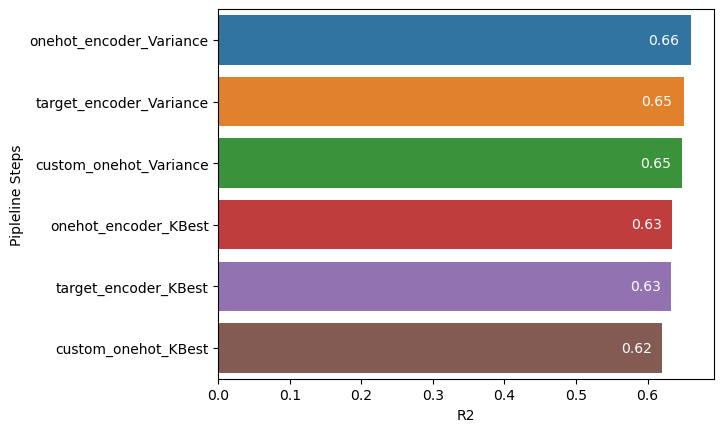

In [10]:
(X_train, X_test, y_train, y_test) = split()
compare_pipelines(X_train, y_train, LinearRegression())

The pipeline that uses the custom OneHotEncoder, and the Variance feature selection yields the best R2 score on a LinearRegression model. However, the feature selection algorithms could yield better results with different hyperparameters. We will therefore use GridSearchCV to help selecting the best values

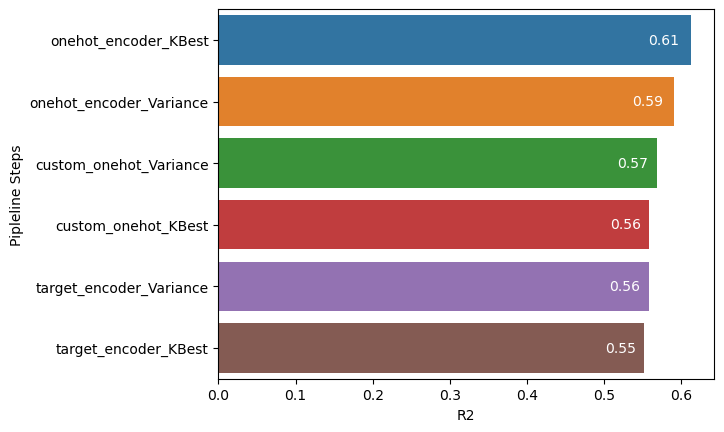

In [11]:
(X_train, X_test, y_train, y_test) = split()
compare_pipelines(X_train, y_train, SVR())

Using SVR, the best score is achieved with OneHotEncoder and the SelectKBest feature selector.

We will test out these selectors with different hyperparameters across different models to see if we can obtain higher scores.

## Identifying optimal parameters with GridSearchCV

**Choice of metric**: 

For the grid search, we will compare three different metrics : R2, RMSE and MAE. 

R2 is easily interpretable, MAE is less impacted by outliers, and RMSE is stricter with large errors.

While we will be looking at all three metrics, we will take a closer look at RMSE, since we aim to predict GHG emissions and energy use and therefore limit the possibility of having large errors.

We will compare two pipelines, one using SelectKBest and one with Variance Threshold

In [12]:
model_comparison = pd.DataFrame()

In [13]:
kbest_params = {
    "selectkbest__k": [5, 7, 8, 10, "all"],
    "selectkbest__score_func": [f_regression],
}

variance_params = {"variancethreshold__threshold": [0.1, 0.3, 0.5, 0.7, 0.9]}

### Linear Regression

In [14]:
def linear_regression_grid_search(additional_params=None, selector=None):
    (X_train, X_test, y_train, y_test) = split()
    param_grid = {}
    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X_train, y_train, LinearRegression(), param_grid, model_comparison, selector
    )


model_comparison = linear_regression_grid_search()

,Model,Selector,Mean R2,Mean MAE,Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.66,0.2413,0.3205,{},0.24,1.28


In [15]:
model_comparison = linear_regression_grid_search(kbest_params, SelectKBest())

,Model,Selector,Mean R2,Mean MAE,Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.66,0.2413,0.3205,{},0.24,1.28
1,LinearRegression(),SelectKBest(),0.59,0.2635,0.3549,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.06,1.46


In [16]:
model_comparison = linear_regression_grid_search(variance_params, VarianceThreshold())

,Model,Selector,Mean R2,Mean MAE,Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.66,0.2413,0.3205,{},0.24,1.28
2,LinearRegression(),VarianceThreshold(),0.65,0.2442,0.3249,{'variancethreshold__threshold': 0.9},0.04,0.58
1,LinearRegression(),SelectKBest(),0.59,0.2635,0.3549,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.06,1.46


### SVR

#### Without selector

In [17]:
def svr_grid_search(additional_params=None, selector=None):
    (X_train, X_test, y_train, y_test) = split()
    param_grid = {
        "svr__C": [1, 3, 5, 100],
        "svr__epsilon": [1e-2, 0.5, 1, 2, 5, 10],
    }
    if additional_params:
        param_grid.update(additional_params)

    return grid_search(X_train, y_train, SVR(), param_grid, model_comparison, selector)


model_comparison = svr_grid_search()

,Model,Selector,Mean R2,Mean MAE,Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.66,0.2413,0.3205,{},0.24,1.28
1,LinearRegression(),VarianceThreshold(),0.65,0.2442,0.3249,{'variancethreshold__threshold': 0.9},0.04,0.58
2,LinearRegression(),SelectKBest(),0.59,0.2635,0.3549,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.06,1.46
3,SVR(),None,0.58,0.2725,0.3575,"{'svr__C': 1, 'svr__epsilon': 2}",0.06,4.09


#### With SelectKBest Selector

In [18]:
model_comparison = svr_grid_search(kbest_params, SelectKBest())

,Model,Selector,Mean R2,Mean MAE,Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.66,0.2413,0.3205,{},0.24,1.28
1,LinearRegression(),VarianceThreshold(),0.65,0.2442,0.3249,{'variancethreshold__threshold': 0.9},0.04,0.58
2,LinearRegression(),SelectKBest(),0.59,0.2635,0.3549,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.06,1.46
3,SVR(),None,0.58,0.2725,0.3575,"{'svr__C': 1, 'svr__epsilon': 2}",0.06,4.09
4,SVR(),SelectKBest(),0.57,0.2696,0.3615,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>, 'svr__C': 1, 'svr__epsilon': 2}",0.11,30.27


#### With Variance Threshold Selector

In [19]:
model_comparison = svr_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Mean R2,Mean MAE,Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.66,0.2413,0.3205,{},0.24,1.28
1,LinearRegression(),VarianceThreshold(),0.65,0.2442,0.3249,{'variancethreshold__threshold': 0.9},0.04,0.58
2,LinearRegression(),SelectKBest(),0.59,0.2635,0.3549,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.06,1.46
3,SVR(),None,0.58,0.2725,0.3575,"{'svr__C': 1, 'svr__epsilon': 2}",0.06,4.09
5,SVR(),VarianceThreshold(),0.58,0.2747,0.3603,"{'svr__C': 100, 'svr__epsilon': 0.01, 'variancethreshold__threshold': 0.9}",0.05,15.98
4,SVR(),SelectKBest(),0.57,0.2696,0.3615,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>, 'svr__C': 1, 'svr__epsilon': 2}",0.11,30.27


### ElasticNet

#### Without selector

In [20]:
def elastic_grid_search(additional_params=None, selector=None):
    (X_train, X_test, y_train, y_test) = split()
    param_grid = {
        "elasticnet__alpha": [1, 10, 15, 20],
        "elasticnet__l1_ratio": [1e-2, 1e-1, 0.3, 0.5, 0.8, 1],
        "elasticnet__max_iter": [3000],
        "elasticnet__random_state": [42],
    }
    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X_train, y_train, ElasticNet(), param_grid, model_comparison, selector
    )


model_comparison = elastic_grid_search()

,Model,Selector,Mean R2,Mean MAE,Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.66,0.2413,0.3205,{},0.24,1.28
1,LinearRegression(),VarianceThreshold(),0.65,0.2442,0.3249,{'variancethreshold__threshold': 0.9},0.04,0.58
2,LinearRegression(),SelectKBest(),0.59,0.2635,0.3549,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.06,1.46
3,SVR(),None,0.58,0.2725,0.3575,"{'svr__C': 1, 'svr__epsilon': 2}",0.06,4.09
4,SVR(),VarianceThreshold(),0.58,0.2747,0.3603,"{'svr__C': 100, 'svr__epsilon': 0.01, 'variancethreshold__threshold': 0.9}",0.05,15.98
5,SVR(),SelectKBest(),0.57,0.2696,0.3615,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>, 'svr__C': 1, 'svr__epsilon': 2}",0.11,30.27
6,ElasticNet(),None,0.43,0.3287,0.4197,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.05,5.47


#### With SelectKBest selector

In [21]:
model_comparison = elastic_grid_search(
    kbest_params,
    SelectKBest(),
)

,Model,Selector,Mean R2,Mean MAE,Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.66,0.2413,0.3205,{},0.24,1.28
1,LinearRegression(),VarianceThreshold(),0.65,0.2442,0.3249,{'variancethreshold__threshold': 0.9},0.04,0.58
2,LinearRegression(),SelectKBest(),0.59,0.2635,0.3549,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.06,1.46
3,SVR(),None,0.58,0.2725,0.3575,"{'svr__C': 1, 'svr__epsilon': 2}",0.06,4.09
4,SVR(),VarianceThreshold(),0.58,0.2747,0.3603,"{'svr__C': 100, 'svr__epsilon': 0.01, 'variancethreshold__threshold': 0.9}",0.05,15.98
5,SVR(),SelectKBest(),0.57,0.2696,0.3615,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>, 'svr__C': 1, 'svr__epsilon': 2}",0.11,30.27
6,ElasticNet(),None,0.43,0.3287,0.4197,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.05,5.47
7,ElasticNet(),SelectKBest(),0.39,0.3389,0.4317,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.04,17.12


#### With VarianceThreshold selector

In [22]:
model_comparison = elastic_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Mean R2,Mean MAE,Mean RMSE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,0.66,0.2413,0.3205,{},0.24,1.28
1,LinearRegression(),VarianceThreshold(),0.65,0.2442,0.3249,{'variancethreshold__threshold': 0.9},0.04,0.58
2,LinearRegression(),SelectKBest(),0.59,0.2635,0.3549,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.06,1.46
3,SVR(),None,0.58,0.2725,0.3575,"{'svr__C': 1, 'svr__epsilon': 2}",0.06,4.09
4,SVR(),VarianceThreshold(),0.58,0.2747,0.3603,"{'svr__C': 100, 'svr__epsilon': 0.01, 'variancethreshold__threshold': 0.9}",0.05,15.98
5,SVR(),SelectKBest(),0.57,0.2696,0.3615,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>, 'svr__C': 1, 'svr__epsilon': 2}",0.11,30.27
6,ElasticNet(),None,0.43,0.3287,0.4197,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.05,5.47
8,ElasticNet(),VarianceThreshold(),0.43,0.3288,0.4200,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.04,13.54
7,ElasticNet(),SelectKBest(),0.39,0.3389,0.4317,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.04,17.12


### RandomForest

#### Without selector

In [23]:
def random_forest_grid_search(additional_params=None, selector=None):
    (X_train, X_test, y_train, y_test) = split()
    param_grid = {
        "randomforestregressor__n_estimators": [50, 70, 100, 120],
        "randomforestregressor__min_samples_split": [2, 4, 6, 8],
        "randomforestregressor__max_features": ["sqrt", "log2", None],
        "randomforestregressor__criterion": [
            "squared_error",
            "friedman_mse",
            "poisson",
        ],
        "randomforestregressor__random_state": [42],
    }

    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X_train,
        y_train,
        RandomForestRegressor(),
        param_grid,
        model_comparison,
        selector,
    )


model_comparison = random_forest_grid_search()

,Model,Selector,Mean R2,Mean MAE,Mean RMSE,Best params,Mean Fit Time,Runtime
9,RandomForestRegressor(),None,0.67,0.2429,0.3194,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.13,237.96
0,LinearRegression(),None,0.66,0.2413,0.3205,{},0.24,1.28
1,LinearRegression(),VarianceThreshold(),0.65,0.2442,0.3249,{'variancethreshold__threshold': 0.9},0.04,0.58
2,LinearRegression(),SelectKBest(),0.59,0.2635,0.3549,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.06,1.46
3,SVR(),None,0.58,0.2725,0.3575,"{'svr__C': 1, 'svr__epsilon': 2}",0.06,4.09
4,SVR(),VarianceThreshold(),0.58,0.2747,0.3603,"{'svr__C': 100, 'svr__epsilon': 0.01, 'variancethreshold__threshold': 0.9}",0.05,15.98
5,SVR(),SelectKBest(),0.57,0.2696,0.3615,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>, 'svr__C': 1, 'svr__epsilon': 2}",0.11,30.27
6,ElasticNet(),None,0.43,0.3287,0.4197,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.05,5.47
7,ElasticNet(),VarianceThreshold(),0.43,0.3288,0.4200,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.04,13.54
8,ElasticNet(),SelectKBest(),0.39,0.3389,0.4317,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.04,17.12


#### With SelectKBest selector

In [24]:
model_comparison = random_forest_grid_search(
    kbest_params,
    SelectKBest(),
)

,Model,Selector,Mean R2,Mean MAE,Mean RMSE,Best params,Mean Fit Time,Runtime
0,RandomForestRegressor(),None,0.67,0.2429,0.3194,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.13,237.96
1,LinearRegression(),None,0.66,0.2413,0.3205,{},0.24,1.28
2,LinearRegression(),VarianceThreshold(),0.65,0.2442,0.3249,{'variancethreshold__threshold': 0.9},0.04,0.58
3,LinearRegression(),SelectKBest(),0.59,0.2635,0.3549,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.06,1.46
4,SVR(),None,0.58,0.2725,0.3575,"{'svr__C': 1, 'svr__epsilon': 2}",0.06,4.09
5,SVR(),VarianceThreshold(),0.58,0.2747,0.3603,"{'svr__C': 100, 'svr__epsilon': 0.01, 'variancethreshold__threshold': 0.9}",0.05,15.98
6,SVR(),SelectKBest(),0.57,0.2696,0.3615,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>, 'svr__C': 1, 'svr__epsilon': 2}",0.11,30.27
10,RandomForestRegressor(),SelectKBest(),0.56,0.2739,0.3649,"{'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.14,821.11
7,ElasticNet(),None,0.43,0.3287,0.4197,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.05,5.47
8,ElasticNet(),VarianceThreshold(),0.43,0.3288,0.4200,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.04,13.54


#### With VarianceThreshold selector

In [25]:
model_comparison = random_forest_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Mean R2,Mean MAE,Mean RMSE,Best params,Mean Fit Time,Runtime
0,RandomForestRegressor(),None,0.67,0.2429,0.3194,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.13,237.96
1,LinearRegression(),None,0.66,0.2413,0.3205,{},0.24,1.28
2,LinearRegression(),VarianceThreshold(),0.65,0.2442,0.3249,{'variancethreshold__threshold': 0.9},0.04,0.58
11,RandomForestRegressor(),VarianceThreshold(),0.65,0.2493,0.3271,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'variancethreshold__threshold': 0.9}",0.07,709.44
3,LinearRegression(),SelectKBest(),0.59,0.2635,0.3549,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.06,1.46
4,SVR(),None,0.58,0.2725,0.3575,"{'svr__C': 1, 'svr__epsilon': 2}",0.06,4.09
5,SVR(),VarianceThreshold(),0.58,0.2747,0.3603,"{'svr__C': 100, 'svr__epsilon': 0.01, 'variancethreshold__threshold': 0.9}",0.05,15.98
6,SVR(),SelectKBest(),0.57,0.2696,0.3615,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>, 'svr__C': 1, 'svr__epsilon': 2}",0.11,30.27
7,RandomForestRegressor(),SelectKBest(),0.56,0.2739,0.3649,"{'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.14,821.11
8,ElasticNet(),None,0.43,0.3287,0.4197,"{'elasticnet__alpha': 10, 'elasticnet__l1_ratio': 0.3, 'elasticnet__max_iter': 3000, 'elasticnet__random_state': 42}",0.05,5.47


### Gradient Boosting

#### Without Selector

In [26]:
def gradient_boosting_grid_search(additional_params=None, selector=None):
    (X_train, X_test, y_train, y_test) = split()
    param_grid = {
        "gradientboostingregressor__n_estimators": [120, 150, 200],
        "gradientboostingregressor__loss": [
            "squared_error",
            "absolute_error",
            "huber",
            "quantile",
        ],
        "gradientboostingregressor__min_samples_split": [6, 8, 10],
        "gradientboostingregressor__max_features": ["sqrt", "log2", 1.0],
        "gradientboostingregressor__random_state": [42],
    }

    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X_train,
        y_train,
        GradientBoostingRegressor(),
        param_grid,
        model_comparison,
        selector,
    )


model_comparison = gradient_boosting_grid_search()

,Model,Selector,Mean R2,Mean MAE,Mean RMSE,Best params,Mean Fit Time,Runtime
12,GradientBoostingRegressor(),None,0.67,0.2437,0.3180,"{'gradientboostingregressor__loss': 'quantile', 'gradientboostingregressor__max_features': 1.0, 'gradientboostingregressor__min_samples_split': 6, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42}",0.09,188.19
0,RandomForestRegressor(),None,0.67,0.2429,0.3194,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.13,237.96
1,LinearRegression(),None,0.66,0.2413,0.3205,{},0.24,1.28
2,LinearRegression(),VarianceThreshold(),0.65,0.2442,0.3249,{'variancethreshold__threshold': 0.9},0.04,0.58
3,RandomForestRegressor(),VarianceThreshold(),0.65,0.2493,0.3271,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'variancethreshold__threshold': 0.9}",0.07,709.44
4,LinearRegression(),SelectKBest(),0.59,0.2635,0.3549,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.06,1.46
5,SVR(),None,0.58,0.2725,0.3575,"{'svr__C': 1, 'svr__epsilon': 2}",0.06,4.09
6,SVR(),VarianceThreshold(),0.58,0.2747,0.3603,"{'svr__C': 100, 'svr__epsilon': 0.01, 'variancethreshold__threshold': 0.9}",0.05,15.98
7,SVR(),SelectKBest(),0.57,0.2696,0.3615,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>, 'svr__C': 1, 'svr__epsilon': 2}",0.11,30.27
8,RandomForestRegressor(),SelectKBest(),0.56,0.2739,0.3649,"{'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.14,821.11


#### With SelectKBest Selector


In [27]:
model_comparison = gradient_boosting_grid_search(
    kbest_params,
    SelectKBest(),
)

,Model,Selector,Mean R2,Mean MAE,Mean RMSE,Best params,Mean Fit Time,Runtime
0,GradientBoostingRegressor(),None,0.67,0.2437,0.3180,"{'gradientboostingregressor__loss': 'quantile', 'gradientboostingregressor__max_features': 1.0, 'gradientboostingregressor__min_samples_split': 6, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42}",0.09,188.19
1,RandomForestRegressor(),None,0.67,0.2429,0.3194,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.13,237.96
2,LinearRegression(),None,0.66,0.2413,0.3205,{},0.24,1.28
3,LinearRegression(),VarianceThreshold(),0.65,0.2442,0.3249,{'variancethreshold__threshold': 0.9},0.04,0.58
4,RandomForestRegressor(),VarianceThreshold(),0.65,0.2493,0.3271,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'variancethreshold__threshold': 0.9}",0.07,709.44
13,GradientBoostingRegressor(),SelectKBest(),0.60,0.2615,0.3493,"{'gradientboostingregressor__loss': 'quantile', 'gradientboostingregressor__max_features': 1.0, 'gradientboostingregressor__min_samples_split': 6, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.16,716.94
5,LinearRegression(),SelectKBest(),0.59,0.2635,0.3549,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.06,1.46
6,SVR(),None,0.58,0.2725,0.3575,"{'svr__C': 1, 'svr__epsilon': 2}",0.06,4.09
7,SVR(),VarianceThreshold(),0.58,0.2747,0.3603,"{'svr__C': 100, 'svr__epsilon': 0.01, 'variancethreshold__threshold': 0.9}",0.05,15.98
8,SVR(),SelectKBest(),0.57,0.2696,0.3615,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>, 'svr__C': 1, 'svr__epsilon': 2}",0.11,30.27


#### With VarianceThreshold selector

In [28]:
model_comparison = gradient_boosting_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Mean R2,Mean MAE,Mean RMSE,Best params,Mean Fit Time,Runtime
0,GradientBoostingRegressor(),None,0.67,0.2437,0.3180,"{'gradientboostingregressor__loss': 'quantile', 'gradientboostingregressor__max_features': 1.0, 'gradientboostingregressor__min_samples_split': 6, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42}",0.09,188.19
1,RandomForestRegressor(),None,0.67,0.2429,0.3194,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_split': 6, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.13,237.96
2,LinearRegression(),None,0.66,0.2413,0.3205,{},0.24,1.28
14,GradientBoostingRegressor(),VarianceThreshold(),0.66,0.2488,0.3229,"{'gradientboostingregressor__loss': 'quantile', 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_split': 6, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42, 'variancethreshold__threshold': 0.9}",0.07,433.78
3,LinearRegression(),VarianceThreshold(),0.65,0.2442,0.3249,{'variancethreshold__threshold': 0.9},0.04,0.58
4,RandomForestRegressor(),VarianceThreshold(),0.65,0.2493,0.3271,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'variancethreshold__threshold': 0.9}",0.07,709.44
5,GradientBoostingRegressor(),SelectKBest(),0.60,0.2615,0.3493,"{'gradientboostingregressor__loss': 'quantile', 'gradientboostingregressor__max_features': 1.0, 'gradientboostingregressor__min_samples_split': 6, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__random_state': 42, 'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.16,716.94
6,LinearRegression(),SelectKBest(),0.59,0.2635,0.3549,"{'selectkbest__k': 5, 'selectkbest__score_func': <function f_regression at 0x166da15a0>}",0.06,1.46
7,SVR(),None,0.58,0.2725,0.3575,"{'svr__C': 1, 'svr__epsilon': 2}",0.06,4.09
8,SVR(),VarianceThreshold(),0.58,0.2747,0.3603,"{'svr__C': 100, 'svr__epsilon': 0.01, 'variancethreshold__threshold': 0.9}",0.05,15.98


# Predictions 

In [29]:
linear_regression = build_pipeline(LinearRegression())
linear_regression.fit(X_train, y_train)
linear_regression.score(X_test, y_test)

0.6586166027989884

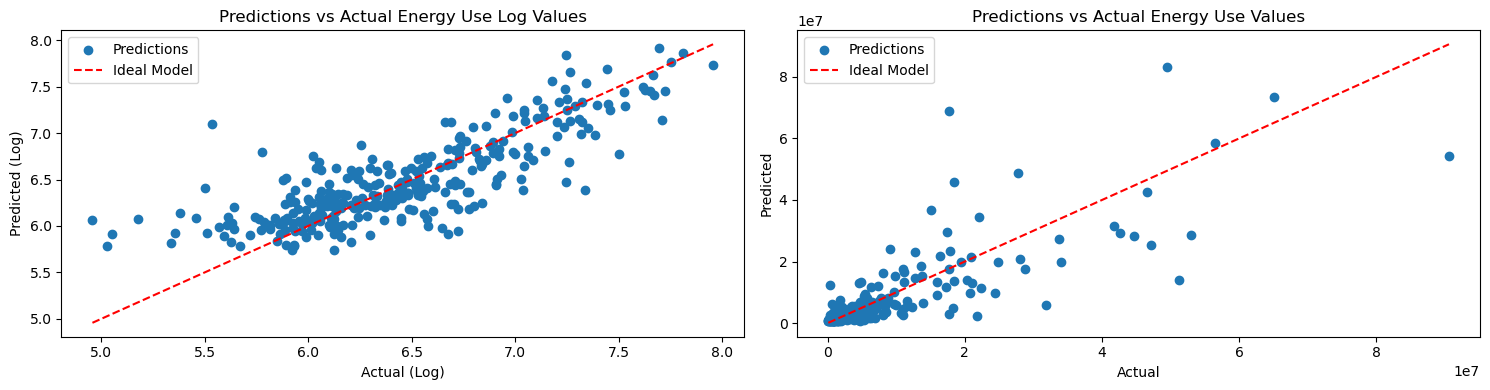

In [30]:
plot_predictions(y_test, linear_regression.predict(X_test))

In [31]:
random_forest = build_pipeline(
    RandomForestRegressor(
        criterion="friedman_mse",
        max_features=1.0,
        n_estimators=50,
        random_state=42,
        min_samples_split=6,
    )
)

random_forest.fit(X_train, y_train)
random_forest.score(X_test, y_test)

0.6367666426180494

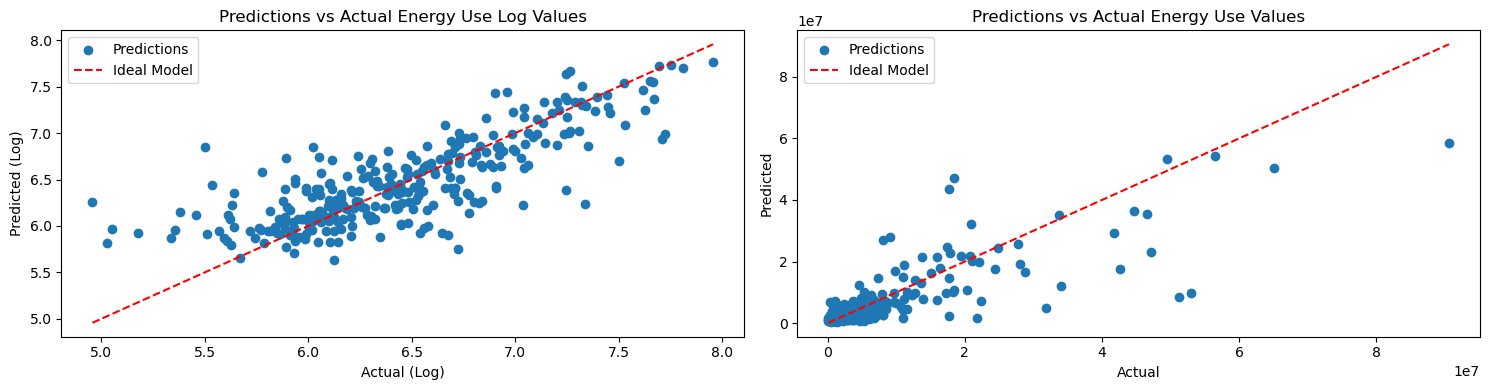

In [32]:
predictions = random_forest.predict(X_test)
plot_predictions(y_test, predictions)

# EnergyStarScore

First we get a baseline measure of our model without the EnergyStarScore

In [33]:
y = energy_data["SiteEnergyUse(kBtu)"]
X_with_score = energy_data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
    ],
    axis=1,
)
X_without_score = energy_data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
        "NumberOfYearsENERGYSTARCertified",
        "ENERGYSTARScore",
    ],
    axis=1,
)

In [34]:
(X_train, X_test, y_train, y_test) = train_test_split(
    X_without_score, y, test_size=0.2, random_state=42
)

In [35]:
random_forest = build_pipeline(
    RandomForestRegressor(
        criterion="friedman_mse",
        max_features=1.0,
        n_estimators=50,
        random_state=42,
        min_samples_split=6,
    )
)

random_forest.fit(X_train, y_train)
random_forest.score(X_test, y_test)

0.7206570022745197

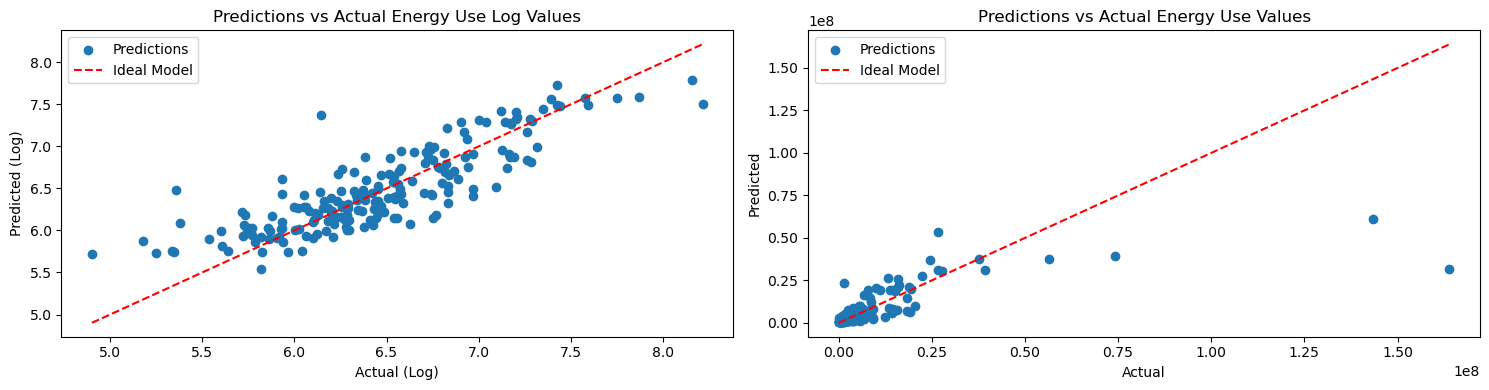

In [36]:
plot_predictions(y_test, random_forest.predict(X_test))

We can now compare it with the score of the model with the EnergyStarScore information

In [37]:
(X_train, X_test, y_train, y_test) = train_test_split(
    X_with_score, y, test_size=0.2, random_state=42
)

In [38]:
random_forest = build_pipeline(
    RandomForestRegressor(
        criterion="friedman_mse",
        max_features=1.0,
        n_estimators=50,
        random_state=42,
        min_samples_split=6,
    )
)

random_forest.fit(X_train, y_train)
random_forest.score(X_test, y_test)

0.7975980123581287

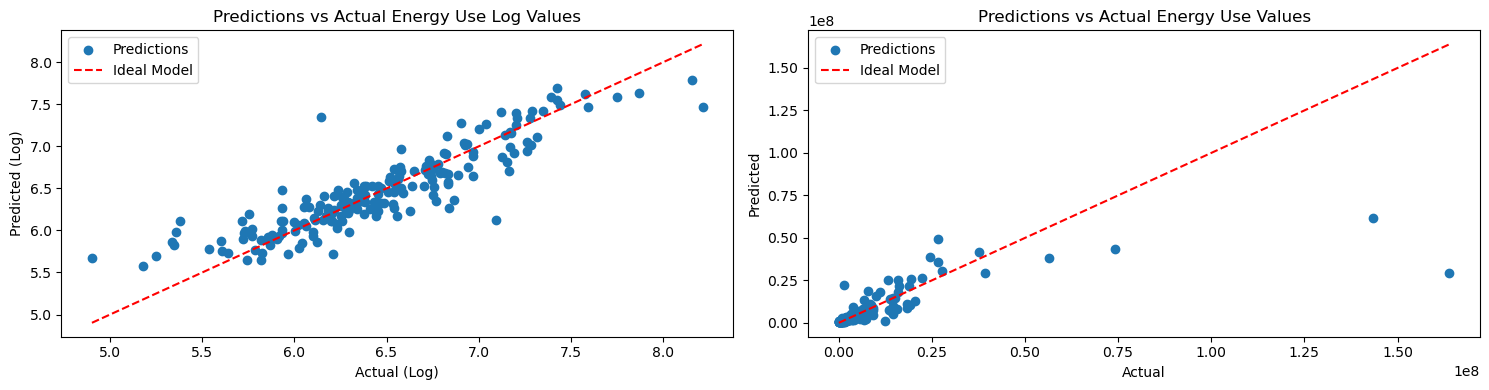

In [39]:
plot_predictions(y_test, random_forest.predict(X_test))